In [1]:
import pandas as pd
import numpy as np
from numpy.random import *
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

def row(x):    #行
    return x.reshape(1,-1)

def column(x):     #列
    return x.reshape(-1,1)

def row2array(x):
    return x[0,:]

def column2array(x):
    x=x.T
    return x[0,:]

def lorenz(v, t):   #列ベクトルをarrayに変換してからぶち込む
    x=v[0]
    y=v[1]
    z=v[2]
    s = 10
    r = 28
    b = 8/3
    return np.array([s*(y-x), r*x-y-x*z, -b*z+x*y])
 
def myoutput(x,t):   #xには、列ベクトルを入れること
    rand = np.random.normal(0, 1, (3, 1))
    dt=0.01
    x=x + dt*rand
    return column(x)


Populating the interactive namespace from numpy and matplotlib


##  Here, we perform estimation simulation using nonlinear dynamics called Lorenz equation.

$$
    \sigma = 10, r = 28, b = \frac{8}{3}
$$

$$
    {\dot{x} = \sigma(y-x)\\
\dot{y} = rx -y-z\\
\dot{z} = -bz + xy
}
$$

In [2]:
#分散の初期設定
Rtr = 0.3
R = np.diag([0.5, 0.2, 0.1]) #3D
Q = np.diag([2, 4, 3])  #3D
dt = 0.01

# 真値の計算
t = np.linspace(0,50,50/dt+1,dtype=float)#時間　dt=0.01の間隔で0から10秒までの配列
#xtr0 = column(np.array([0.1, 0.5, 1.2]))#2D列 #真値の初期値、行列xtr0の1番目の列
xtr0 = column(np.array([2, 1, 3]))#2D列 #真値の初期値、行列xtr0の1番目の列
ytr0 = myoutput(xtr0,t[0])#2D_列#真値の出力
w0 = np.dot(Q ,np.random.normal(0, 1, (3, 1)))

xtr = xtr0
ytr = ytr0 
w = w0
yt0 = myoutput(xtr0,t[0])#2D_列
yt = yt0

for i in range(1,len(t)):
    k1 = dt * lorenz(xtr[:,i-1], t[i-1] ) #array
    k2 = dt * lorenz(xtr[:,i-1] + k1/2, t[i-1]+dt/2 )   #array
    k3 = dt * lorenz(xtr[:,i-1] + k2/2, t[i-1]+dt/2)   #array
    k4 = dt * lorenz(xtr[:,i-1] + k3,t[i-1]+dt)    #array
    
    w_i = np.dot(Q ,np.random.normal(0, 1, (3, 1)))#3x3と行ベクトルの内積で列ベクトルになる　
    w = np.concatenate([w,w_i],axis=1)    
    
    xtr_i = column(xtr[:,i-1]  +  (k1+2*k2+2*k3+k4) /6 ) +column(w[:,i-1].T*dt)
    xtr = np.concatenate([xtr,xtr_i],axis=1) #列を横に並べる

    ytr_i = myoutput(column(xtr[:,i-1]),t[i-1])#2D_列
    ytr = np.concatenate([ytr,ytr_i],axis=1) #列を横に並べる
    
    ###   観測値の計算   ###
    yt_i = ytr_i+column(np.dot(R,np.random.normal(0, 1, (3, 1))))  
    yt = np.concatenate([yt,yt_i],axis=1)    #3D_行
    

len_y = ytr.shape[0]
len_x = ytr.shape[1]


print(t)
print(t.shape)
print(yt.shape)

[  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   4.99800000e+01
   4.99900000e+01   5.00000000e+01]
(5001,)
(3, 5001)


In [3]:
#  EnKFの初期設定
M = 100   #サンプルの数
barx0 = xtr0 #状態の初期値 2D_列
P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0=column(barx0) #2D_列
# アンサンブル行列Y_0/tの作成
y0 = myoutput( column(x0[:,0]), t[0])  
for i in range(M-1):
        x0_i=barx0 + np.dot(Q,np.random.normal(0, 1, (3, 1))) #2D_列　正規乱数
        x0 = np.concatenate([x0,x0_i],axis=1) #3D_列
        y0_i=myoutput( column(x0[:,0]), t[0]) + np.dot(R,np.random.normal(0, 1, (3, 1))) 
        y0 = np.concatenate([y0,y0_i],axis=1) #3D_列

 


print(x0.shape)   #x0は誤差アンサンブル行列　予測平均値と誤差
print(y0.shape)   #y0は予測出力の誤差アンサンブル行列

(3, 100)
(3, 100)


In [4]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

yest=column(ytr[:,0])

for i in range(len(t)-1):
    x=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat = column(numpy.sum(x0,axis=1) / M ) #2D_列
    yhat = column(numpy.sum(y0,axis=1) / M ) #2D_列
    yest_i = yhat
    yest = np.concatenate([yest,yest_i],axis=1) #3D_列
    Pxy = np.dot( (np.kron(np.eye(1,100),xhat) - x0), (np.kron(np.eye(1,100),yhat) - y0).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy = np.dot( (np.kron(np.eye(1,100),yhat) - y0), (np.kron(np.eye(1,100),yhat) - y0).T ) / (M-1)  #(3x3)  V 共分散行列
    K = np.dot(Pxy, np.linalg.inv(Pyy))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        x_j = column( x0[:,j] + np.dot(K, (yt[:,i] - y0[:,j]) ) ) #2D_列
        x = np.concatenate([x,x_j],axis=1) #3D_列
        x0[:,j] = x[:,j] + column2array(row(lorenz(x[:,j], t[i])).T*dt +np.dot(Q,np.random.normal(0, 1, (3, 1))) * dt )  #array型
        
        y0[:,j] = column2array(  myoutput(column(x0[:,j]),t[i]) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型

            

In [5]:
#print(t.shape)  #(201,) tの真値
#print(xtr.shape)  #(3, 201) xの真値
#print(ytr.shape)  #(3, 201) yの真値
#print(yest.shape)  #(3, 201) yestの真値 #便宜上t=0　を挿入している。

In [6]:
df = pd.DataFrame({ 't' : t ,
                    'xtr1' : xtr[0,:],
                    'xtr2' : xtr[1,:],
                    'xtr3' : xtr[2,:],
                    'ytr1' : ytr[0,:],
                    'ytr2' : ytr[1,:],
                    'ytr3' : ytr[2,:],
                    'yest1' : yest[0,:],
                    'yest2' : yest[1,:],
                    'yest3' : yest[2,:],
                  })

df = df.set_index(['t'])

In [7]:
df1 = pd.DataFrame({ 't' : t ,
                    'yest_x' : yest[0,:],
                    'yest_y' : yest[1,:],
                    'yest_z' : yest[2,:],
                  })
df1 = df1.set_index(['t'])
df[:10]

,xtr1,xtr2,xtr3,yest1,yest2,yest3,ytr1,ytr2,ytr3
t,,,,,,,,,
0.00,2.000000,1.000000,3.000000,2.005277,1.005236,2.993592,2.005277,1.005236,2.993592
0.01,1.927187,1.469877,2.957589,1.946532,0.982586,3.009663,2.006183,1.007174,2.993571
0.02,1.886198,1.935154,2.881053,1.925240,1.845517,2.558038,1.923507,1.467795,2.945027
0.03,1.907362,2.345032,2.791772,1.819857,1.399939,2.920157,1.898116,1.938999,2.902803
0.04,1.992891,2.837729,2.737366,1.769067,1.937701,2.942533,1.898416,2.331249,2.785901
0.05,2.105952,3.316563,2.767570,1.718485,2.475500,2.913416,1.974578,2.833243,2.747305
0.06,2.264501,3.849996,2.757832,1.697945,2.670728,2.638044,2.102618,3.322347,2.774810
0.07,2.448131,4.440036,2.813534,1.962486,3.555431,2.905943,2.272204,3.842006,2.754809
0.08,2.656698,4.954715,2.858401,2.256926,3.843003,2.696488,2.462756,4.430728,2.804659


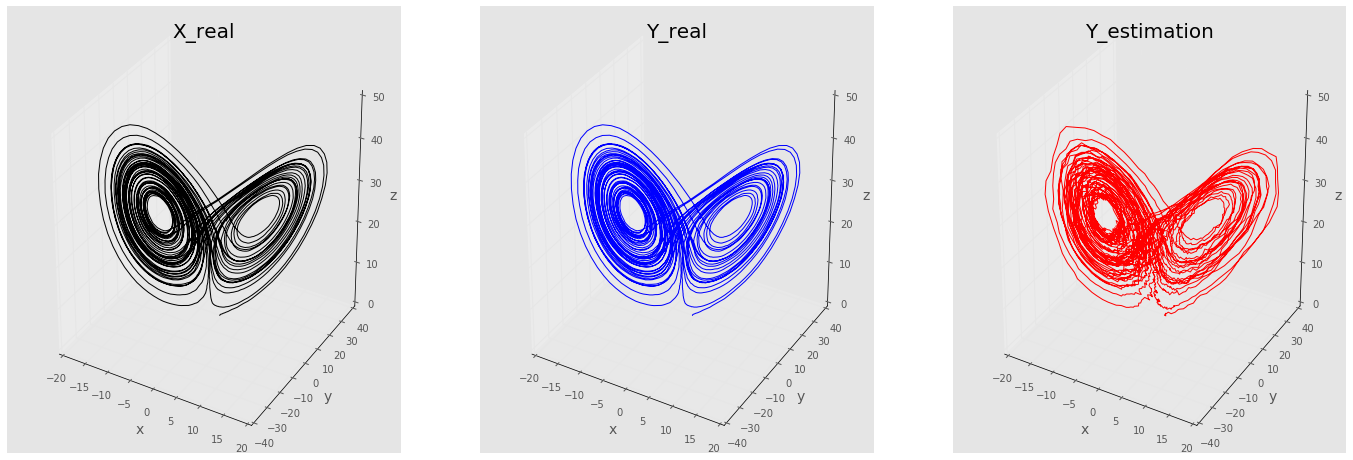

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Figureを追加
fig = plt.figure(figsize = (8*3, 8) )

#軸の範囲
xlim = [-20, 20]
ylim = [-40, 40]
zlim = [0, 50]

# 3DAxesを追加
ax1 = fig.add_subplot(133, projection='3d')

# Axesのタイトルを設定
ax1.set_title("Y_estimation", size = 20)

# 軸ラベルを設定
ax1.set_xlabel("x", size = 14)
ax1.set_ylabel("y", size = 14)
ax1.set_zlabel("z", size = 14)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_zlim(zlim)
x = yest[0,:]
y = yest[1,:]
z = yest[2,:]

# 曲線を描画
ax1.plot(x, y, z, color = "red")


# 3DAxesを追加
ax2 = fig.add_subplot(132, projection='3d')

# Axesのタイトルを設定
ax2.set_title("Y_real", size = 20)

# 軸ラベルを設定
ax2.set_xlabel("x", size = 14)
ax2.set_ylabel("y", size = 14)
ax2.set_zlabel("z", size = 14)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_zlim(zlim)
x = ytr[0,:]
y = ytr[1,:]
z = ytr[2,:]

# 曲線を描画
ax2.plot(x, y, z, color = "blue")

# 3DAxesを追加
ax3 = fig.add_subplot(131, projection='3d')

# Axesのタイトルを設定
ax3.set_title("X_real", size = 20)

# 軸ラベルを設定
ax3.set_xlabel("x", size = 14)
ax3.set_ylabel("y", size = 14)
ax3.set_zlabel("z", size = 14)
ax3.set_xlim(xlim)
ax3.set_ylim(ylim)
ax3.set_zlim(zlim)
x = xtr[0,:]
y = xtr[1,:]
z = xtr[2,:]

# 曲線を描画
ax3.plot(x, y, z, color = "black")